In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
#scikit-learn
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import TransformedTargetRegressor

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, learning_curve, cross_val_score, cross_validate
from sklearn.metrics import mean_squared_error, r2_score, classification_report, mean_absolute_error

import shap
from shap.models import TransformersPipeline

import os
import glob

In [2]:
data_finale = "C:/Users/remid/Documents/_OC_ParcoursDataScientist/P4_Anticipez_Les_Besoins_En_Consommation_De_Bâtiments/2016_Building_Energy_Nettoyage_Final.csv"
df_f = pd.read_csv(data_finale, sep=",")
df = df_f.copy()

In [3]:
# Définie les options d'affichage pour les lignes et colonnes
pd.set_option('display.max_row',100)
pd.set_option('display.max_column',80)
# Supprime les warnings (pour le ridge)
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['axes.titlesize'] = 16  # Taille du titre
plt.rcParams['axes.titlecolor'] = '#000'  # Couleur du titre
plt.rcParams['axes.titlepad'] = 20  # Espace sous le titre du titre

plt.rcParams['axes.labelsize'] = 10  # Taille des labels des axes
plt.rcParams['axes.labelcolor'] = '#000'  # Couleur des labels des axes

plt.rcParams['xtick.labelsize'] = 8  # Taille des labels des ticks x
plt.rcParams['ytick.labelsize'] = 8  # Taille des labels des ticks y
plt.rcParams['xtick.color'] = '#333'  # Couleur des labels des ticks x
plt.rcParams['ytick.color'] = '#333'  # Couleur des labels des ticks y

In [4]:
# deleted columns
df = df_f.drop(columns=["Unnamed: 0","Latitude","Longitude","ENERGYSTARScore","TotalGHGEmissions"])

In [5]:
df.isna().mean().sort_values(ascending=False).head(5)

ThirdLargestPropertyUseType        0.774685
ThirdLargestPropertyUseTypeGFA     0.774685
SecondLargestPropertyUseType       0.451292
SecondLargestPropertyUseTypeGFA    0.451292
Neighborhood                       0.000000
dtype: float64

In [6]:
def imputation(df):
    other_use_type = ["SecondLargestPropertyUseType","SecondLargestPropertyUseTypeGFA",
                      "ThirdLargestPropertyUseType","ThirdLargestPropertyUseTypeGFA"]
    df = df.drop(columns=other_use_type)

    df["Neighborhood"] = df["Neighborhood"].str.upper().replace('DELRIDGE NEIGHBORHOODS',"DELRIDGE")

    print("{}% de valeurs nulles".format(df.isna().mean().sum()))

    return df

In [7]:
def encodage(df):

    categorical_cols = list(df.select_dtypes(include="object").columns)
    numerical_cols = list(df.select_dtypes(include=["int","float"]).columns)
    numerical_cols.remove('SiteEnergyUseWN(kBtu)')

    # Create transformers for preprocessing
    numeric_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())])

    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'))])

    # Combine transformers using ColumnTransformer
    preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
        ])

    print("Pipeline d'encodage OK!")

    return df, preprocessor

In [8]:
def preprocessing(df):

    df = imputation(df)
    df, preprocessor = encodage(df)

    X = df.drop(columns="SiteEnergyUseWN(kBtu)")
    y = df["SiteEnergyUseWN(kBtu)"]

    print("Preprocessing terminé !\n")

    return X, y, preprocessor

In [9]:
trainset, testset = train_test_split(df, test_size=0.2, random_state=42)

In [10]:
X_train, y_train, preprocessor = preprocessing(trainset)
X_test, y_test, preprocessor = preprocessing(testset)

0.0% de valeurs nulles
Pipeline d'encodage OK!

Preprocessing terminé !
0.0% de valeurs nulles
Pipeline d'encodage OK!

Preprocessing terminé !


In [11]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
models = {
    "DecisionTree": DecisionTreeRegressor(random_state=42),
    "RandomForest": RandomForestRegressor(random_state=42),
    "GradientBoosting": GradientBoostingRegressor(random_state=42),
    "KNeighbors": KNeighborsRegressor(),
    "Ridge": Ridge(random_state=42),
    "Lasso": Lasso(random_state=42),
}

In [13]:
# Créez un DataFrame vide pour stocker les résultats
results = pd.DataFrame(columns=["Model", "r2"])

# Bouclez sur chaque modèle dans le dictionnaire 'models'
for name, model in models.items():
    # Create the final pipeline
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', model)])

    # Entraînez le modèle
    pipeline.fit(X_train, y_train)
    
    # Faites des prédictions sur l'ensemble de test
    predictions = pipeline.predict(X_test)
    
    # Calcule du r2
    score = r2_score(y_test, predictions)

    # Ajoutez le nom du modèle et son score au DataFrame
    results.loc[len(results)] = [name, score]
    
    # Ajoutez le nom du modèle et son score au DataFrame
    #results = results.append({"Model": name, "r2": score}, ignore_index=True)
results.sort_values(by="r2", ascending=False)

,Model,r2
2,GradientBoosting,0.395096
1,RandomForest,0.355545
5,Lasso,0.331131
4,Ridge,0.322878
3,KNeighbors,0.312815
0,DecisionTree,0.278162


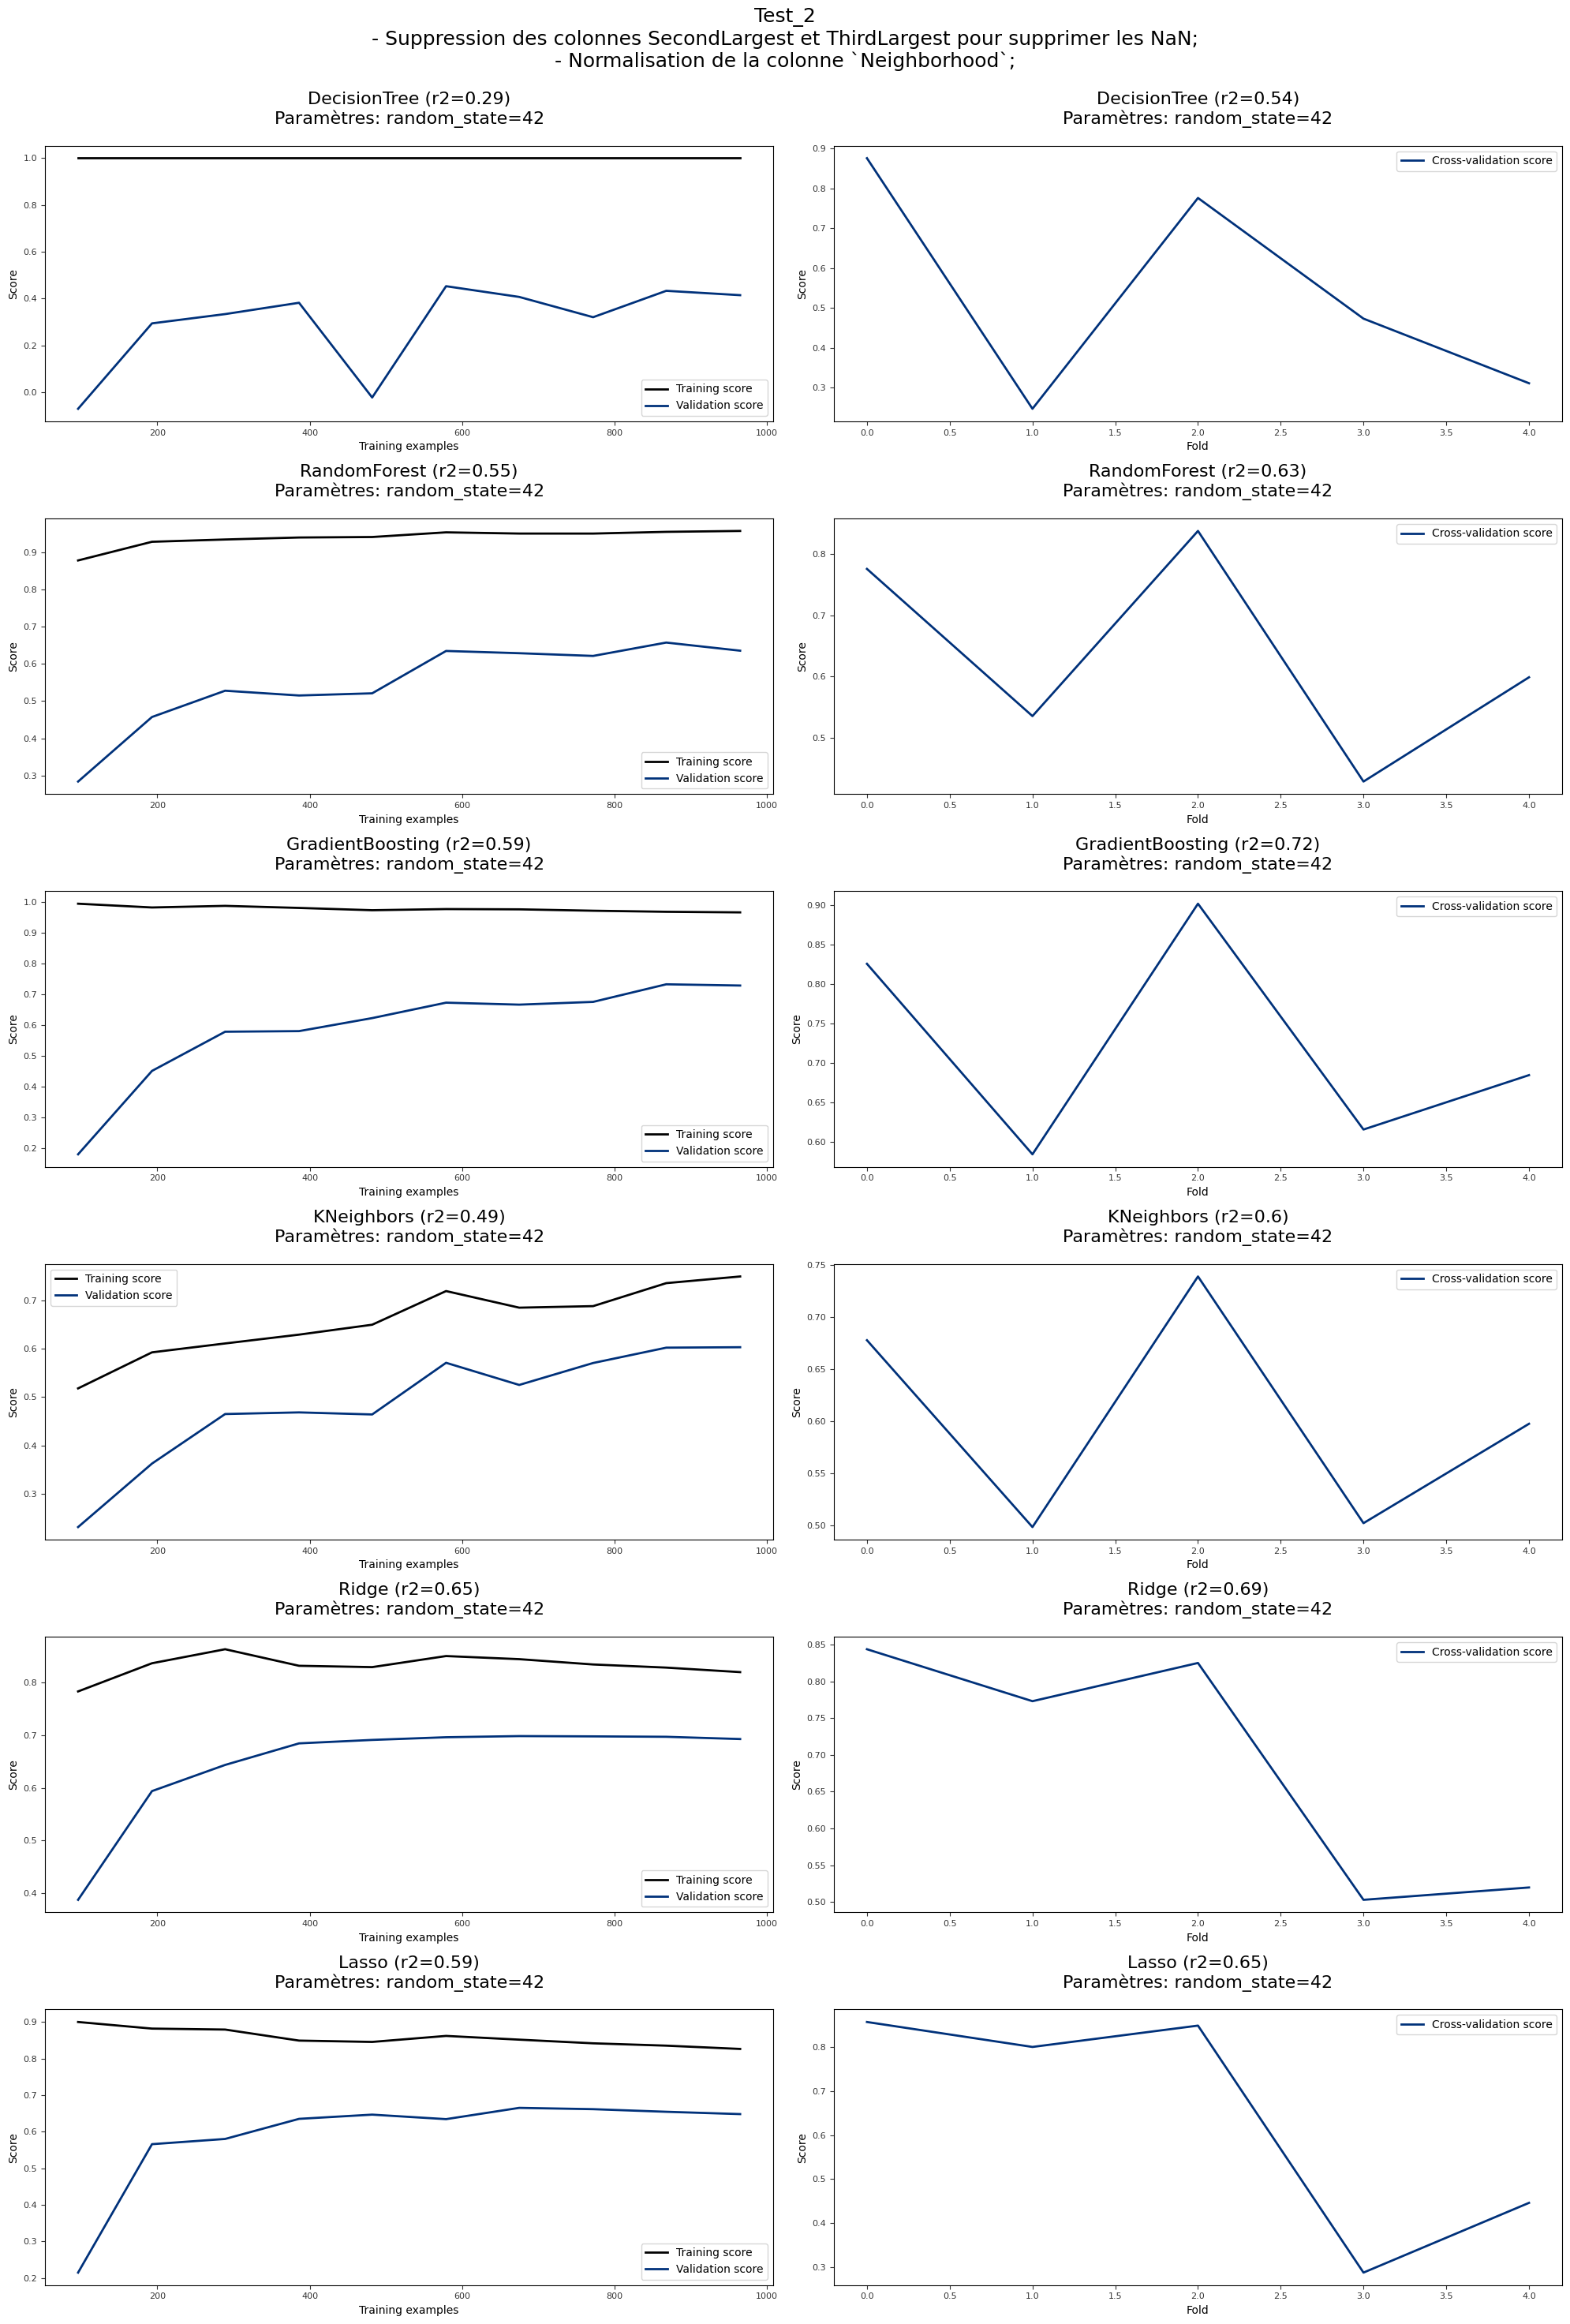

In [14]:
# Obtenez une liste de tous les fichiers qui correspondent au motif "Test_*.jpeg"
files = glob.glob("./P4_ResultsModels/Test_*.jpeg")

# Triez cette liste en fonction du numéro dans le nom du fichier
files.sort(key=lambda x: int(x.split("_")[-1].split(".")[0]))

# Prenez le dernier élément de la liste, extrayez le numéro du fichier à partir de son nom, et incrémentez-le
if files:
    last_file_num = int(files[-1].split("_")[-1].split(".")[0]) + 1
else:
    last_file_num = 1
    
# Define number of subplots per line
n_plots_per_row = 2
# Détail sur le test effectué
commentaire = f"""- Suppression des colonnes SecondLargest et ThirdLargest pour supprimer les NaN;
- Normalisation de la colonne `Neighborhood`;"""

# Create a figure with several subplots
fig, axes = plt.subplots(nrows=len(models), ncols=n_plots_per_row, figsize=(20, 5*len(models)))
# Add a unique title for each target
plt.suptitle(f"Test_{last_file_num}\n{commentaire}\n\n", color="#000", fontsize=18)

# Bouclez sur chaque modèle dans le dictionnaire 'models'
for i, (name, model) in enumerate(models.items()):
    # Créez le pipeline final
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('model', model)])
    
    # Entraînez le modèle
    pipeline.fit(X_train, y_train)
    
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)

    # Obtenez les courbes d'apprentissage
    N, train_scores, val_scores = learning_curve(pipeline, X_train, y_train, cv=kfold, scoring='r2', train_sizes=np.linspace(0.1, 1, 10))
    
    # Obtenez les scores de validation croisée
    scores = cross_val_score(pipeline, X_train, y_train, cv=kfold, scoring='r2')
    
    # Create a bar graph in the left subplot
    ax = axes[i, 0]    
    # Tracez les courbes d'apprentissage sur le premier graphique
    ax.plot(N, train_scores.mean(axis=1), label='Training score', color="#000", linewidth=2)
    ax.plot(N, val_scores.mean(axis=1), label='Validation score', color="#00317a", linewidth=2)
    ax.set_title(f"{name} (r2={round(val_scores.mean(),2)})\nParamètres: random_state=42")
    ax.set_xlabel("Training examples")
    ax.set_ylabel("Score")
    ax.legend(loc="best")

    # Create a bar graph in the right subplot
    ax = axes[i, 1]
    # Tracez les scores de validation croisée sur le deuxième graphique
    ax.plot(scores, label='Cross-validation score', color="#00317a", linewidth=2)
    ax.set_title(f"{name} (r2={round(scores.mean(),2)})\nParamètres: random_state=42")
    ax.set_xlabel("Fold")
    ax.set_ylabel("Score")
    ax.legend(loc="best")

# Automatically adjust margins to avoid overlapping subplots
plt.tight_layout()
# Créez le nom du fichier avec le nouveau numéro
filename = f"./P4_ResultsModels/Test_{last_file_num}.jpeg"
# Enregistrez le graphique dans le fichier
plt.savefig(filename) 
# Display figure   
plt.show()


# DecisionTreeRegressor

In [ ]:
# Create transformers for preprocessing
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine transformers using ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numerical_cols),
    ('cat', categorical_transformer, categorical_cols)
    ])

In [ ]:
tt = TransformedTargetRegressor(regressor=DecisionTreeRegressor(),func=np.log1p, inverse_func=np.expm1)

# Create the final pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', tt)])

kfold = KFold(n_splits=3, shuffle=True, random_state=42)

param_grid = {
    'model__regressor__random_state': [42],
    'model__regressor__criterion': ['squared_error', 'absolute_error'],
    'model__regressor__max_depth': range(1, 10),
    'model__regressor__min_samples_split': range(2, 10),
    'model__regressor__min_samples_leaf': range(1, 10)
}

# Perform a grid search to find the best model and parameters
grid_search = GridSearchCV(pipeline, param_grid, cv=kfold, verbose=1, scoring='r2', return_train_score=True)
test = grid_search.fit(X_train, y_train)

# Get the best parameters and the best score
best_params = grid_search.best_params_

# Get the results
print(grid_search.best_score_)
print(grid_search.best_estimator_)
print(grid_search.best_params_)

# Brouillon

In [ ]:
# Bouclez sur chaque modèle dans le dictionnaire 'models'
for name, model in models.items():
    # Créez le pipeline final
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', model)])
    
    # Entraînez le modèle
    pipeline.fit(X_train, y_train)
    
    kfold = KFold(n_splits=3, shuffle=True, random_state=42)

    # Obtenez les courbes d'apprentissage
    N, train_scores, valt_scores = learning_curve(pipeline, X_train, y_train, cv=kfold, scoring='r2', train_sizes=np.linspace(0.1, 1, 10))
    
    # Tracez les courbes d'apprentissage
    plt.plot(N, train_scores.mean(axis=1), label='Training score')
    plt.plot(N, valt_scores.mean(axis=1), label='Validation score')
    plt.title(f"Modèle: {name}\nScore r2: {valt_scores.mean()}")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.show()

In [ ]:
# Bouclez sur chaque modèle dans le dictionnaire 'models'
for name, model in models.items():
   # Créez le pipeline final
   pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                        ('model', model)])
   
   # Entraînez le modèle
   pipeline.fit(X_train, y_train)
   
   kfold = KFold(n_splits=5, shuffle=True, random_state=42)

   # Obtenez les scores de validation croisée
   scores = cross_val_score(pipeline, X_train, y_train, cv=kfold, scoring='r2')
   
   # Tracez les scores de validation croisée
   plt.plot(scores, label='Cross-validation score')
   plt.title(f"Modèle: {name}\nScore r2: {scores.mean()}")
   plt.xlabel("Fold")
   plt.ylabel("Score")
   plt.legend(loc="best")
   plt.show()